In [118]:
import arviz
import pyro
import torch
import numpy as np
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
from torch.distributions import constraints
from scipy.stats import multivariate_normal

In [119]:
!mkdir images

mkdir: images: File exists


In [120]:
# The function
g = lambda x: (-(np.sin(6*torch.pi*x))**2) + 6*(x**2) - 5*(x**4) + (3/2)

In [121]:
# create dataset
SIZE = 30
X = torch.linspace(0, 1, SIZE)
y = g(X) + np.random.normal(scale = 0.01, size = (SIZE,))
choose = np.random.choice(SIZE, int(SIZE * 2/3), replace= False)
non_choosen = np.setdiff1d(np.arange(SIZE), choose)
X_train, X_test = X[choose], X[non_choosen]
y_train, y_test = y[choose], y[non_choosen]

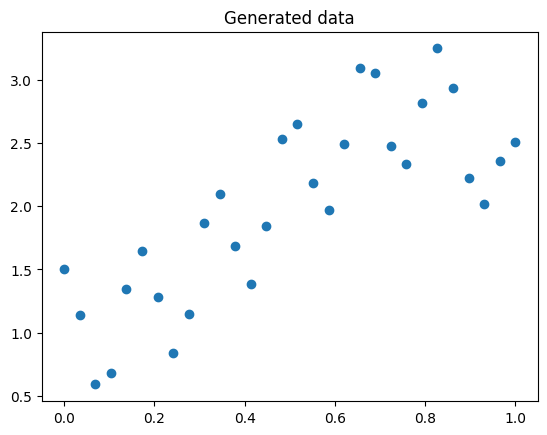

In [122]:
plt.scatter(X, y)
plt.title("Generated data")
plt.show()
plt.close()

Visually inspecting the dataset shows that there is a general upwards trend, and a periodicity around this trend. 

Thus, we have chosen sum an RBF kernel and a Periodic kernel, hoping that the first will model the overall trend, and the latter will capture the periodicity. We fix the variance at 1.0 for both kernels too allow faster training.

Inspired from https://pyro.ai/examples/gp.html
and https://pyro.ai/examples/mle_map.html

In [123]:
# function for creating the GPRegression object with priors

def gen_model(priors = True, period = torch.tensor(1.), lengthPer = torch.tensor(1.), 
              lengthRBF = torch.tensor(1.), varPer = torch.tensor(1.), varRBF= torch.tensor(1.)):
    
    # defining kernels
    periodic = gp.kernels.Periodic(input_dim=1, period=period, lengthscale=lengthPer, variance=varPer)
    rbf = gp.kernels.RBF(input_dim=1, lengthscale=lengthRBF, variance=varRBF)
    k = gp.kernels.Sum(kern0=rbf, kern1=periodic)

    model = gp.models.GPRegression(
        X=X_train,
        y=y_train,
        kernel=k,
        noise= torch.tensor(0.1),
    )
    if priors == True: 
        # RBF Kernel               
        model.kernel.kern0.variance_unconstrained.detach_()
        model.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.5))
        # Periodic Kernel
        model.kernel.kern1.variance_unconstrained.detach_()
        model.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1, 0.5))
        model.kernel.kern1.period = pyro.nn.PyroSample(dist.LogNormal(-1, 0.5))
            
    return model

In [124]:
# training the model to find MAP-estimates

def train_model(model, print_map = False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = 2000 
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(model.model, model.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if print_map == True:
        model.set_mode("guide")
        # MAP
        # print(f"Linear, Variance: {model.kernel.kern0.variance.item()}\n")

        print(f"RBF, Variance: {model.kernel.kern0.variance.item()}")
        print(f"RBF, Lengthscale: {model.kernel.kern0.lengthscale.item()}\n")
        print(f"Periodic Kernel, Variance: {model.kernel.kern1.variance.item()}")
        print(f"Periodic Kernel, Lengthscale: {model.kernel.kern1.lengthscale.item()}\n")
        print(f"Periodic Kernel, Period: {model.kernel.kern1.period.item()}")
        print(f"Noise: {model.noise.item()}")
    
    return model

In [125]:
# plotting model predictions
def plot_model(model, X_train, X_test, y_train, y_test):
    plt.scatter(X_test, y_test, label = "Test data")
    plt.scatter(X_train, y_train, label = "Training data")
    x_space = np.linspace(0, 1, 300)
    y_space = g(x_space)
    plt.plot(x_space, y_space, label = "G(x)")
    with torch.no_grad():
        mean, var = model(X_test, noiseless = False) # a.k.a posterior predictive
    plt.plot(X_test, mean, color="C3", label = "Predictions")
    plt.scatter(X_test, mean, color = "C3", s = 2, )
    plt.fill_between(X_test, (mean + 1.95*var.sqrt()), (mean - 1.95*var.sqrt()), alpha = 0.1, color = "C0")
    plt.legend()


In [126]:
# calculate posterior likelihood on test data with trained model/MAP estimates
def MAP_likelihood(model, X_test, y_test):
    with torch.no_grad():
        mean, cov = model(X_test, full_cov = True, noiseless = False)
    return multivariate_normal.pdf(y_test, mean, cov)

In [127]:
# train GP model using MCMC to allow sampling from posterior for parameters
def MCMC(model, i = 0):
    nuts_kernel = pyro.infer.NUTS(model.model, jit_compile=True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=250, num_chains=2, warmup_steps=100)
    mcmc.run()

    data = arviz.from_pyro(mcmc)
    summary = arviz.summary(data)
    print(summary)

    arviz.plot_posterior(data)
    plt.tight_layout()
    plt.savefig(f"./images/nuts_posterior_{i}.png")
    plt.close()
    arviz.plot_trace(data)
    plt.tight_layout()
    plt.savefig(f"./images/nuts_trace_{i}.png")
    plt.close()
    samples = mcmc.get_samples()

    return samples

# calculate posterior likelihood of test data using samples from posterior on parameters
def NUTS_likelihood(model, X_test, y_test, n_samples = 500, i = 0):
    samples = MCMC(model, i)
    plot_model(model, X_train, X_test, y_train, y_test)
    plt.tight_layout()
    plt.savefig("./images/nuts_predictions_" + str(i) + ".png")
    plt.close()
    posterior_predictive = []
    
    for i in range(n_samples):
        pyro.clear_param_store()
        fixed_model = gen_model(
            priors = False,
            lengthRBF=samples['kernel.kern0.lengthscale'][i], 
            lengthPer=samples['kernel.kern1.lengthscale'][i],
            period=samples["kernel.kern1.period"][i]
            )

        with torch.no_grad():
            mean, cov = fixed_model(X_test, full_cov=True, noiseless = False)
            posterior_predictive.append((mean, cov))
            
    likelihood = [multivariate_normal.pdf(y_test, mean, cov) for mean, cov in posterior_predictive]
    likelihood = torch.mean(torch.tensor(likelihood))
    
    return likelihood

In [128]:
map_likelihood_collection = []
nuts_likelihood_collection = []

for i in range(20):    
    # create dataset
    X = torch.linspace(0, 1, SIZE)
    y = g(X) + np.random.normal(scale = 0.01, size = (SIZE,))
    choose = np.random.choice(SIZE, int(SIZE * 2/3), replace= False)
    non_choosen = np.setdiff1d(np.arange(SIZE), choose)
    X_train, X_test = X[choose], X[non_choosen]
    y_train, y_test = y[choose], y[non_choosen]
    
    # train MAP model
    pyro.clear_param_store()
    model1 = gen_model()
    train_model(model1)
    plot_model(model1, X_train, X_test, y_train, y_test)
    plt.tight_layout()
    plt.savefig("./images/map_predictions_" + str(i) + ".png")
    plt.close()
    map_likelihood = MAP_likelihood(model1, X_test, y_test)
    
    #train NUTS model
    pyro.clear_param_store()
    model2 = gen_model()
    nuts_likelihood = NUTS_likelihood(model2, X_test, y_test, i = i)
    
    map_likelihood_collection.append(map_likelihood)
    nuts_likelihood_collection.append(nuts_likelihood.item())

Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.659  0.237   0.301    1.026      0.056    0.040   
kernel.kern1.lengthscale  0.916  0.291   0.322    1.381      0.023    0.016   
kernel.kern1.period       0.386  0.192   0.299    0.510      0.081    0.061   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      23.0      84.0   1.07  
kernel.kern1.lengthscale     150.0     259.0   1.03  
kernel.kern1.period            4.0      14.0   1.57  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.571  0.199   0.276    0.935      0.012    0.009   
kernel.kern1.lengthscale  1.011  0.451   0.222    1.744      0.042    0.030   
kernel.kern1.period       0.256  0.086   0.162    0.356      0.060    0.050   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     357.0     204.0   1.02  
kernel.kern1.lengthscale      87.0      46.0   1.13  
kernel.kern1.period            3.0      40.0   1.84  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.587  0.200   0.267    0.954      0.015    0.011   
kernel.kern1.lengthscale  0.916  0.405   0.136    1.571      0.024    0.017   
kernel.kern1.period       0.255  0.084   0.165    0.350      0.058    0.049   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     205.0     175.0   1.00  
kernel.kern1.lengthscale     228.0      77.0   1.05  
kernel.kern1.period            3.0     125.0   1.84  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.609  0.173   0.353    0.985      0.012    0.009   
kernel.kern1.lengthscale  0.987  0.305   0.521    1.617      0.044    0.032   
kernel.kern1.period       0.391  0.183   0.303    0.528      0.063    0.046   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     222.0     213.0   1.01  
kernel.kern1.lengthscale      33.0     149.0   1.08  
kernel.kern1.period            5.0      29.0   1.45  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.632  0.207   0.335    0.996      0.013    0.010   
kernel.kern1.lengthscale  0.954  0.278   0.478    1.545      0.013    0.009   
kernel.kern1.period       0.332  0.010   0.313    0.351      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     323.0     222.0    1.0  
kernel.kern1.lengthscale     432.0     255.0    1.0  
kernel.kern1.period          395.0     313.0    1.0  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.795  0.362   0.301    1.492      0.085    0.061   
kernel.kern1.lengthscale  0.835  0.348   0.242    1.379      0.107    0.078   
kernel.kern1.period       0.601  0.393   0.278    1.372      0.213    0.165   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      21.0     192.0   1.08  
kernel.kern1.lengthscale       9.0     110.0   1.19  
kernel.kern1.period            3.0      60.0   1.89  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.747  0.303   0.256    1.302      0.064    0.046   
kernel.kern1.lengthscale  0.743  0.269   0.322    1.226      0.128    0.098   
kernel.kern1.period       0.568  0.275   0.315    1.066      0.170    0.137   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      33.0      81.0   1.07  
kernel.kern1.lengthscale       4.0     212.0   1.46  
kernel.kern1.period            3.0      59.0   1.87  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.808  0.487   0.273    1.636      0.124    0.090   
kernel.kern1.lengthscale  0.788  0.320   0.275    1.326      0.149    0.113   
kernel.kern1.period       0.593  0.340   0.316    1.171      0.186    0.146   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      18.0     109.0   1.13  
kernel.kern1.lengthscale       4.0      77.0   1.39  
kernel.kern1.period            3.0     124.0   1.72  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.658  0.194   0.344    1.000      0.012    0.008   
kernel.kern1.lengthscale  0.861  0.254   0.414    1.350      0.083    0.061   
kernel.kern1.period       0.418  0.083   0.320    0.522      0.057    0.048   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     273.0     246.0   1.00  
kernel.kern1.lengthscale      10.0      96.0   1.14  
kernel.kern1.period            3.0     199.0   1.83  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.756  0.271   0.317    1.262      0.097    0.071   
kernel.kern1.lengthscale  0.798  0.318   0.279    1.353      0.113    0.083   
kernel.kern1.period       0.571  0.280   0.311    1.041      0.168    0.134   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale       8.0     155.0   1.19  
kernel.kern1.lengthscale       8.0      91.0   1.19  
kernel.kern1.period            3.0      40.0   1.86  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.629  0.249   0.322    1.008      0.019    0.014   
kernel.kern1.lengthscale  0.941  0.404   0.171    1.650      0.033    0.023   
kernel.kern1.period       0.254  0.084   0.163    0.350      0.059    0.050   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     287.0     190.0   1.03  
kernel.kern1.lengthscale     120.0      44.0   1.09  
kernel.kern1.period            3.0     133.0   1.83  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.625  0.197   0.288    0.978      0.012    0.009   
kernel.kern1.lengthscale  0.967  0.269   0.485    1.492      0.013    0.009   
kernel.kern1.period       0.340  0.011   0.321    0.358      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     256.0     292.0    1.0  
kernel.kern1.lengthscale     402.0     248.0    1.0  
kernel.kern1.period          285.0     250.0    1.0  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.696  0.218   0.327    1.093      0.010    0.007   
kernel.kern1.lengthscale  0.845  0.260   0.373    1.349      0.087    0.064   
kernel.kern1.period       0.416  0.085   0.315    0.518      0.059    0.049   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     426.0     325.0   1.00  
kernel.kern1.lengthscale       9.0     269.0   1.18  
kernel.kern1.period            3.0     209.0   1.83  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_ten

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.717  0.261   0.310    1.153      0.073    0.053   
kernel.kern1.lengthscale  0.753  0.302   0.320    1.344      0.155    0.119   
kernel.kern1.period       0.540  0.216   0.313    0.861      0.143    0.118   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      14.0     339.0   1.10  
kernel.kern1.lengthscale       4.0     304.0   1.47  
kernel.kern1.period            3.0      17.0   1.87  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.657  0.302   0.258    1.131      0.067    0.048   
kernel.kern1.lengthscale  0.999  0.301   0.426    1.451      0.047    0.033   
kernel.kern1.period       0.451  0.365   0.161    1.180      0.104    0.076   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      16.0     112.0   1.09  
kernel.kern1.lengthscale      47.0     152.0   1.02  
kernel.kern1.period           15.0      38.0   1.89  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.572  0.166   0.302    0.875      0.014    0.010   
kernel.kern1.lengthscale  1.015  0.458   0.323    1.826      0.061    0.043   
kernel.kern1.period       0.256  0.086   0.163    0.355      0.060    0.050   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     134.0     213.0   1.01  
kernel.kern1.lengthscale      52.0      96.0   1.08  
kernel.kern1.period            3.0     147.0   1.83  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.690  0.210   0.370    1.119      0.053    0.038   
kernel.kern1.lengthscale  0.821  0.276   0.407    1.346      0.110    0.082   
kernel.kern1.period       0.481  0.190   0.325    0.715      0.107    0.084   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      15.0     184.0   1.10  
kernel.kern1.lengthscale       6.0      91.0   1.29  
kernel.kern1.period            3.0      79.0   1.98  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.699  0.262   0.285    1.038      0.027    0.019   
kernel.kern1.lengthscale  0.929  0.334   0.418    1.585      0.083    0.060   
kernel.kern1.period       0.537  0.294   0.305    1.125      0.126    0.094   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     134.0     123.0   1.06  
kernel.kern1.lengthscale      14.0     167.0   1.10  
kernel.kern1.period            4.0      83.0   1.42  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.684  0.226   0.343    1.129      0.014    0.010   
kernel.kern1.lengthscale  0.747  0.302   0.225    1.287      0.125    0.093   
kernel.kern1.period       0.213  0.127   0.085    0.349      0.088    0.074   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     305.0     215.0   1.02  
kernel.kern1.lengthscale       6.0     210.0   1.27  
kernel.kern1.period            3.0      64.0   1.84  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.755  0.318   0.299    1.333      0.031    0.022   
kernel.kern1.lengthscale  0.997  0.422   0.259    1.644      0.046    0.032   
kernel.kern1.period       0.250  0.082   0.161    0.350      0.057    0.048   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     117.0     162.0   1.04  
kernel.kern1.lengthscale      64.0      49.0   1.08  
kernel.kern1.period            3.0     182.0   1.83  


In [129]:
map_likelihood_collection
print(f"Mean {np.mean(map_likelihood_collection):.3f}, SD {np.std(map_likelihood_collection):.3f}")

Mean 101072845773.469, SD 415103310565.748


In [130]:
nuts_likelihood_collection
print(f"Mean {np.mean(nuts_likelihood_collection):.3f}, SD {np.std(nuts_likelihood_collection):.3f}")

Mean 0.213, SD 0.140


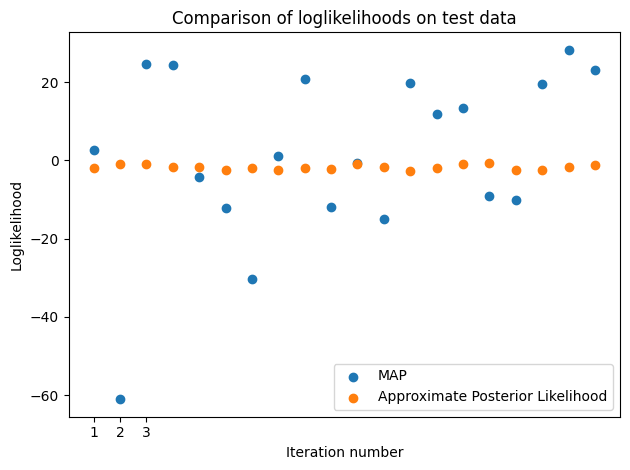

In [131]:
plt.scatter(range(1, 21), np.log(map_likelihood_collection), label = "MAP")
plt.scatter(range(1, 21), np.log(nuts_likelihood_collection), label = "Approximate Posterior Likelihood")
plt.ylabel("Loglikelihood")
plt.xlabel("Iteration number")
plt.xticks(range(1, 4))
plt.title("Comparison of loglikelihoods on test data")
plt.tight_layout()
plt.savefig("Likelihood_comparison.png")
plt.legend()
plt.show()